# Converting annotations to object segmentation mask images

**Overview:** 

The DSA database stores annotations in an (x,y) coordinate list format. Some
object localization algorithms like Faster-RCNN take coordinate formats whereas
others (eg Mask R-CNN) require some form of object segmentation mask image
whose pixel values encode not only class but instance information (so that
individual objects of the same class can be distinguished).

This notebook demonstrates tools to convert annotations into contours or masks that can be used with algorithms like Mask-RCNN. There are two approaches for generating these data:

* Generate contours or an object segmentation mask image from a region defined by user-specified coordinates.

* Generate contours or object segmentation mask images from annotations contained within _region-of-interest_ (ROI) annotations. This involves mapping annotations to these ROIs and creating one image per ROI.

The examples below extend approaches described in Amgad et al, 2019:

*Mohamed Amgad, Habiba Elfandy, Hagar Hussein, ..., Jonathan Beezley, Deepak R Chittajallu, David Manthey, David A Gutman, Lee A D Cooper, Structured crowdsourcing enables convolutional segmentation of histology images, Bioinformatics, , btz083, https://doi.org/10.1093/bioinformatics/btz083*

A csv file like the one in
``histomicstk/annotations_and_masks/tests/test_files/sample_GTcodes.csv`` is needed to define what group each pixel value corresponds to in the mask image, to define the overlay order of various annotation groups, and which groups are considered to be ROIs. Note that the term "group" here comes from the annotation model where each group represents a class like "tumor" or "necrosis" and is associated with a an annotation style.

**What is the difference between this and `annotations_to_masks_handler`?**

The difference between this and version 1, found at
`histomicstk.annotations_and_masks.annotations_to_masks_handler`
is that this (version 2) gets the contours first, including cropping
to wanted ROI boundaries and other processing using shapely, and then
parses these into masks. This enables us to differentiate various objects
to use the data for object localization/classification/segmentation
tasks. If you would like to get semantic segmentation masks instead, i.e. you do
not care about individual objects, you can use either version 1
or this handler using the `semantic` run mode. 
They re-use much of the same code-base, but some edge cases maybe better handled 
by version 1. For example, since this version uses shapely first to crop, some 
objects may be incorrectly parsed by shapely. Version 1, using `PIL.ImageDraw` 
may not have these problems.

**Bottom line is**: if you need semantic segmentation masks, it is probably
safer to use version 1 (annotations to masks handler), whereas if you need object segmentation masks, this handler should be used in `object` run mode.


**Where to look?**

```
   |_ histomicstk/
     |_annotations_and_masks/
     |  |_annotation_and_mask_utils.py
     |  |_annotations_to_object_mask_handler.py
     |_tests/
         |_ test_annotation_and_mask_utils.py
         |_ test_annotations_to_object_mask_handler.py
```

In [1]:
import os

import copy
import girder_client
from pandas import DataFrame, read_csv
import tempfile
from imageio import imread
import matplotlib.pyplot as plt
%matplotlib inline

from histomicstk.annotations_and_masks.annotation_and_mask_utils import (
    get_bboxes_from_slide_annotations,
    scale_slide_annotations, get_scale_factor_and_appendStr)
from histomicstk.annotations_and_masks.annotations_to_object_mask_handler import (
    annotations_to_contours_no_mask, contours_to_labeled_object_mask,
    get_all_rois_from_slide_v2)

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 7, 7
titlesize = 16

## Connect girder client and set parameters

In [2]:
CWD = os.getcwd()

APIURL = 'http://candygram.neurology.emory.edu:8080/api/v1/'
SAMPLE_SLIDE_ID = '5d586d57bd4404c6b1f28640'
GTCODE_PATH = os.path.join(CWD, '../../tests/test_files/sample_GTcodes.csv')

# connect to girder client
gc = girder_client.GirderClient(apiUrl=APIURL)
# gc.authenticate(interactive=True)
gc.authenticate(apiKey='kri19nTIGOkWH01TbzRqfohaaDWb6kPecRqGmemb')

# just a temp directory to save masks for now
BASE_SAVEPATH = tempfile.mkdtemp()
SAVEPATHS = {
    'mask': os.path.join(BASE_SAVEPATH, 'masks'),
    'rgb': os.path.join(BASE_SAVEPATH, 'rgbs'),
    'contours': os.path.join(BASE_SAVEPATH, 'contours'),
    'visualization': os.path.join(BASE_SAVEPATH, 'vis'),
}
for _, savepath in SAVEPATHS.items():
    os.mkdir(savepath)
    
# What resolution do we want to get the images at?
# Microns-per-pixel / Magnification (either or)
MPP = 2.5  # <- this roughly translates to 4x magnification
MAG = None

### Let's inspect the ground truth codes file

This contains the ground truth codes and information dataframe.
This is a dataframe that is indexed by the annotation group name and
has the following columns:

- ```group```: group name of annotation (string), eg. "mostly_tumor"
- ```overlay_order```: int, how early to place the annotation in the
    mask. Larger values means this annotation group is overlayed
    last and overwrites whatever overlaps it.
- ```GT_code```: int, desired ground truth code (in the labeled mask)
    Pixels of this value belong to corresponding group (class)
- ```is_roi```: Flag for whether this group marks 'special' annotations that encode the ROI boundary
- ```is_background_class```: Flag, whether this group is the default
    fill value inside the ROI. For example, you may descide that
    any pixel inside the ROI is considered stroma.
    
**NOTE:** 

Zero pixels have special meaning and do not encode specific ground truth class. Instead, they simply
mean 'Outside ROI' and should be ignored during model training or evaluation.

In [3]:
# read GTCodes file
GTCodes_dict = read_csv(GTCODE_PATH)
GTCodes_dict.index = GTCodes_dict.loc[:, 'group']
GTCodes_dict = GTCodes_dict.to_dict(orient='index')

In [4]:
GTCodes_dict.keys()

dict_keys(['roi', 'evaluation_roi', 'mostly_tumor', 'mostly_stroma', 'mostly_lymphocytic_infiltrate', 'necrosis_or_debris', 'glandular_secretions', 'mostly_blood', 'exclude', 'metaplasia_NOS', 'mostly_fat', 'mostly_plasma_cells', 'other_immune_infiltrate', 'mostly_mucoid_material', 'normal_acinus_or_duct', 'lymphatics', 'undetermined', 'nerve', 'skin_adnexia', 'blood_vessel', 'angioinvasion', 'mostly_dcis', 'other'])

In [5]:
GTCodes_dict['mostly_tumor']

{'group': 'mostly_tumor',
 'overlay_order': 1,
 'GT_code': 1,
 'is_roi': 0,
 'is_background_class': 0,
 'color': 'rgb(255,0,0)',
 'comments': 'core class'}

## Generate contours for user-defined region

Algorithms like Mask-RCNN consume coordinate data describing the boundaries of objects. The function ``annotations_to_contours_no_mask`` generates this countour data for user-specified region. These coordinate data in these contours is relative to the region frame instead of the whole-slide image frame.

In [6]:
print(annotations_to_contours_no_mask.__doc__)

Process annotations to get RGB and contours without intermediate masks.

    Parameters
    ----------
    gc : object
        girder client object to make requests, for example:
        gc = girder_client.GirderClient(apiUrl = APIURL)
        gc.authenticate(interactive=True)

    slide_id : str
        girder id for item (slide)

    MPP : float or None
        Microns-per-pixel -- best use this as it's more well-defined than
        magnification which is more scanner or manufacturer specific.
        MPP of 0.25 often roughly translates to 40x

    MAG : float or None
        If you prefer to use whatever magnification is reported in slide.
        If neither MPP or MAG is provided, everything is retrieved without
        scaling at base (scan) magnification.

    mode : str
        This specifies which part of the slide to get the mask from. Allowed
        modes include the following
        - wsi: get scaled up or down version of mask of whole slide
        - min_bounding_box: g

### More input parameters

These optional parameters describe the desired magnification or resolution of the output, and whether to generate an RGB image for the region and a visualization image of the annotations.

In [7]:
# common params for annotations_to_contours_no_mask()
annotations_to_contours_kwargs = {
    'MPP': MPP, 'MAG': MAG,
    'linewidth': 0.2,
    'get_rgb': True,
    'get_visualization': True,
    'text': False,
}

### 1. manual_bounds mode

As shown in the example for generating semantic segmentation masks, this method can be run in four run modes: 1. `wsi` 2. `min_bounding_box` 3. `manual_bounds` 4. `polygonal_bounds`. Here we test the basic 'manual_bounds' mode where the boundaries of the region you want are provided at base/scan magnification.

In [8]:
bounds = {
    'XMIN': 58000, 'XMAX': 63000,
    'YMIN': 35000, 'YMAX': 39000
}

In [9]:
# get specified region, let the method get and scale annotations
roi_out = annotations_to_contours_no_mask(
    gc=gc, slide_id=SAMPLE_SLIDE_ID,
    mode='manual_bounds', bounds=bounds,
    **annotations_to_contours_kwargs)

/home/mtageld/Desktop/HistomicsTK/histomicstk/annotations_and_masks/annotation_and_mask_utils.py:668: RuntimeWarning: invalid value encountered in greater
  iou = iou[:, iou[1, :] > iou_thresh].astype(int)


The result is an rgb image, contours and a visualization. Let's take a look at these below.

In [10]:
roi_out.keys()

dict_keys(['rgb', 'contours', 'bounds', 'visualization'])

In [11]:
roi_out['bounds']

{'XMIN': 57994, 'XMAX': 62994, 'YMIN': 34999, 'YMAX': 38992}

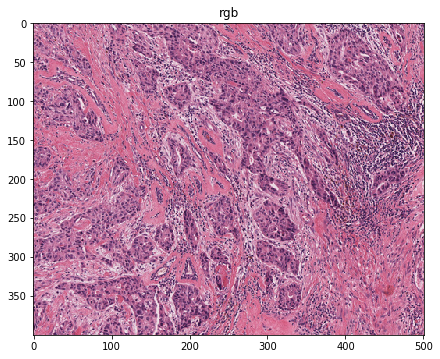

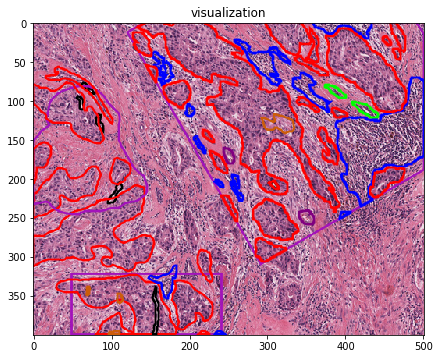

In [12]:
for imstr in ['rgb', 'visualization']:
    plt.imshow(roi_out[imstr])
    plt.title(imstr)
    plt.show()

In [13]:
DataFrame(roi_out['contours']).head()

,annidx,annotation_girder_id,elementidx,element_girder_id,type,group,label,color,xmin,xmax,ymin,ymax,bbox_area,coords_x,coords_y
0,0,5d586d58bd4404c6b1f28642,0,5a943eb992ca9a0016fae97f,rectangle,roi,roi,"rgb(163, 19, 186)",121,501,0,310,117800,"491,143,121,292,501,501,491","0,0,13,310,189,15,0"
1,1,5d586d58bd4404c6b1f28644,0,5a943eb992ca9a0016fae981,polyline,blood_vessel,blood_vessel,"rgb(128,0,128)",341,360,241,259,342,"353,352,351,350,350,349,348,347,346,345,344,34...","241,241,241,241,242,242,242,242,242,242,242,24..."
2,1,5d586d58bd4404c6b1f28644,1,5a943eb992ca9a0016fae982,polyline,blood_vessel,blood_vessel,"rgb(128,0,128)",244,258,161,181,280,"244,244,244,244,244,244,245,245,245,245,245,24...","161,162,163,165,166,167,167,168,169,170,171,17..."
3,2,5d586d58bd4404c6b1f2864c,0,5a943eba92ca9a0016fae990,polyline,mostly_lymphocytic_infiltrate,mostly_lymphocytic_infiltrate,"rgb(0,0,255)",388,501,71,236,18645,"501,501,500,500,499,498,498,497,496,495,495,49...","171,75,75,74,74,74,73,73,72,72,71,71,71,71,72,..."
4,2,5d586d58bd4404c6b1f2864c,1,5a943eba92ca9a0016fae994,polyline,mostly_lymphocytic_infiltrate,mostly_lymphocytic_infiltrate,"rgb(0,0,255)",359,434,0,21,1575,"434,359,359,359,360,360,360,361,361,362,362,36...","0,0,1,2,2,3,4,5,6,6,7,7,7,7,7,8,8,8,9,9,11,12,..."


Note that if the above function call is made repeatedly for the same slide
(e.g. to iterate over multiple regions), multiple get requests would be created to retrieve annotations from the server. To improve efficiency when handling multiple regions in the same slide, we could manually get annotations
and scale them down/up to desired resolution, and pass them to `annotations_to_contours_no_mask()`.

In [14]:
# get annotations for slide
slide_annotations = gc.get('/annotation/item/' + SAMPLE_SLIDE_ID)

# scale up/down annotations by a factor
sf, _ = get_scale_factor_and_appendStr(
    gc=gc, slide_id=SAMPLE_SLIDE_ID, MPP=MPP, MAG=MAG)
slide_annotations = scale_slide_annotations(slide_annotations, sf=sf)

# get bounding box information for all annotations
element_infos = get_bboxes_from_slide_annotations(slide_annotations)

In [15]:
# get specified region -- manually providing scaled annotations
roi_out = annotations_to_contours_no_mask(
    gc=gc, slide_id=SAMPLE_SLIDE_ID,
    mode='manual_bounds', bounds=bounds,
    slide_annotations=slide_annotations, element_infos=element_infos,
    **annotations_to_contours_kwargs)

/home/mtageld/Desktop/HistomicsTK/histomicstk/annotations_and_masks/annotation_and_mask_utils.py:668: RuntimeWarning: invalid value encountered in greater
  iou = iou[:, iou[1, :] > iou_thresh].astype(int)


In [16]:
roi_out['bounds']

{'XMIN': 57994, 'XMAX': 62994, 'YMIN': 34999, 'YMAX': 38992}

### 2. min_bounding_box mode

In `min_bounding_box` mode everything in the slide is handled using the smallest rectangular bounding box.

In [17]:
# get ROI bounding everything
minbbox_out = annotations_to_contours_no_mask(
    gc=gc, slide_id=SAMPLE_SLIDE_ID,
    mode='min_bounding_box', **annotations_to_contours_kwargs)

In [18]:
minbbox_out['bounds']

{'XMIN': 56726, 'YMIN': 33483, 'XMAX': 63732, 'YMAX': 39890}

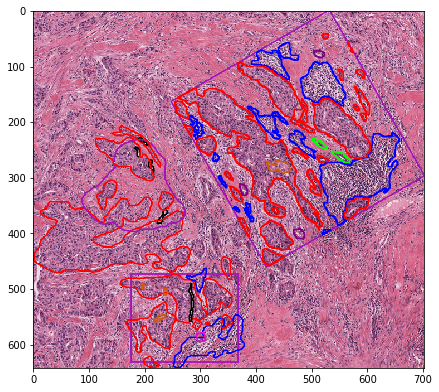

In [19]:
plt.imshow(minbbox_out['visualization'])

### 3. wsi mode
`wsi` mode creates a scaled version of the entire whole-slide image and all annotations contained within.

**NOTE:**

This does not rely on tiles and processes the image at whatever magnification you want. 
You can supress the RGB or visualization outputs and to just fetch the contours or object segmentation mask (see below), providing a bigger magnification range before encountering memory problems.

In [20]:
# get entire wsi region
get_kwargs = copy.deepcopy(annotations_to_contours_kwargs)
get_kwargs['MPP'] = 5.0  # otherwise it's too large!
wsi_out = annotations_to_contours_no_mask(
    gc=gc, slide_id=SAMPLE_SLIDE_ID,
    mode='wsi', **get_kwargs)

In [21]:
wsi_out['bounds']

{'XMIN': 0, 'XMAX': 131516, 'YMIN': 0, 'YMAX': 80439}

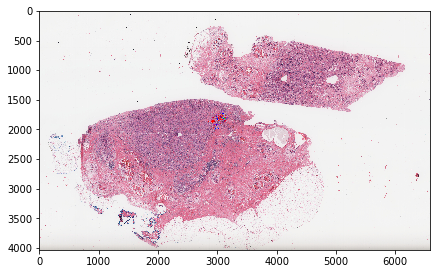

In [22]:
plt.imshow(wsi_out['visualization'])
plt.show()

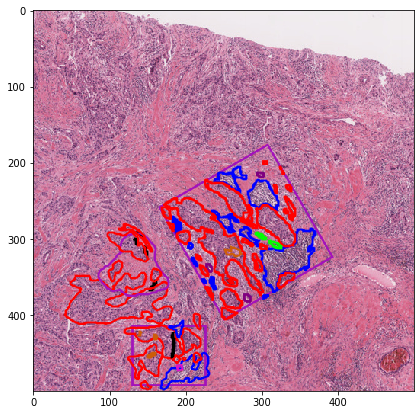

In [23]:
plt.imshow(wsi_out['visualization'][1500:2000, 2800:3300])
plt.show()

## Parse manually-drawn ROIs into separate labeled object masks

This function utilizes the __polygonal_bounds__ mode of the `get_image_and_mask_from_slide()` method to generate a set of outputs for each ROI annotation.

In the example above we focused on generating contour data to represent objects. Below we focus on generating object segmentation mask images.

In [24]:
print(get_all_rois_from_slide_v2.__doc__)

Get all ROIs for a slide without an intermediate mask form.

    This mainly relies on contours_to_labeled_object_mask(), which should
    be referred to for extra documentation.

    This can be run in either the "object" mode, whereby the saved masks
    are a three-channel png where first channel encodes class label (i.e.
    same as semantic segmentation) and the product of the values in the
    second and third channel encodes the object ID. Otherwise, the user
    may decide to run in the "semantic" mode and the resultant mask would
    consist of only one channel (semantic segmentation with no object
    differentiation).

    The difference between this and version 1, found at
    histomicstk.annotations_and_masks.annotations_to_masks_handler.
    get_all_rois_from_slide()
    is that this (version 2) gets the contours first, including cropping
    to wanted ROI boundaries and other processing using shapely, and THEN
    parses these into masks. This enables us to differentiate

The above method mainly relies on `contours_to_labeled_object_mask()`, described below.

In [25]:
print(contours_to_labeled_object_mask.__doc__)

Process contours to get and object segmentation labeled mask.

    Parameters
    ----------
    contours : DataFrame
        contours corresponding to annotation elemeents from the slide.
        All coordinates are relative to the mask that you want to output.
        The following columns are expected.
        - group: str, annotation group (ground truth label).
        - ymin: int, minimun y coordinate
        - ymax: int, maximum y coordinate
        - xmin: int, minimum x coordinate
        - xmax: int, maximum x coordinate
        - coords_x: str, vertix x coordinates comma-separated values
        - coords_y: str, vertix y coordinated comma-separated values

    gtcodes : DataFrame
        the ground truth codes and information dataframe.
        This is a dataframe that is indexed by the annotation group name
        and has the following columns.
        - group: str, group name of annotation, eg. mostly_tumor.
        - GT_code: int, desired ground truth code (in the mask).


In [26]:
get_all_rois_kwargs = {
    'gc': gc,
    'slide_id': SAMPLE_SLIDE_ID,
    'GTCodes_dict': GTCodes_dict,
    'save_directories': SAVEPATHS,
    'annotations_to_contours_kwargs': annotations_to_contours_kwargs,
    'slide_name': 'TCGA-A2-A0YE',
    'mode': 'object',
    'verbose': True,
    'monitorprefix': 'test',
}
savenames = get_all_rois_from_slide_v2(**get_all_rois_kwargs)

test: roi 1 of 3: Overlay level -1: Element 1 of 50: roi
test: roi 1 of 3: Overlay level 1: Element 2 of 50: mostly_tumor
test: roi 1 of 3: Overlay level 1: Element 3 of 50: mostly_lymphocytic_infiltrate
test: roi 1 of 3: Overlay level 1: Element 4 of 50: mostly_tumor
test: roi 1 of 3: Overlay level 1: Element 5 of 50: mostly_tumor
test: roi 1 of 3: Overlay level 1: Element 6 of 50: mostly_lymphocytic_infiltrate
test: roi 1 of 3: Overlay level 1: Element 7 of 50: mostly_lymphocytic_infiltrate
test: roi 1 of 3: Overlay level 1: Element 8 of 50: mostly_lymphocytic_infiltrate
test: roi 1 of 3: Overlay level 1: Element 9 of 50: mostly_tumor
test: roi 1 of 3: Overlay level 1: Element 10 of 50: mostly_lymphocytic_infiltrate
test: roi 1 of 3: Overlay level 1: Element 11 of 50: mostly_tumor
test: roi 1 of 3: Overlay level 1: Element 12 of 50: mostly_tumor
test: roi 1 of 3: Overlay level 1: Element 13 of 50: mostly_tumor
test: roi 1 of 3: Overlay level 1: Element 14 of 50: mostly_tumor
test: ro

In [27]:
savenames[0]

{'mask': '/tmp/tmpvdwsnssq/masks/TCGA-A2-A0YE_left-59191_top-33483_bottom-38083_right-63732.png',
 'rgb': '/tmp/tmpvdwsnssq/rgbs/TCGA-A2-A0YE_left-59191_top-33483_bottom-38083_right-63732.png',
 'visualization': '/tmp/tmpvdwsnssq/vis/TCGA-A2-A0YE_left-59191_top-33483_bottom-38083_right-63732.png',
 'contours': '/tmp/tmpvdwsnssq/contours/TCGA-A2-A0YE_left-59191_top-33483_bottom-38083_right-63732.csv'}

### Let's visualize the contours

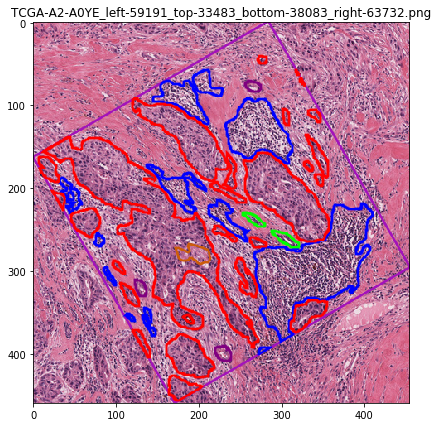

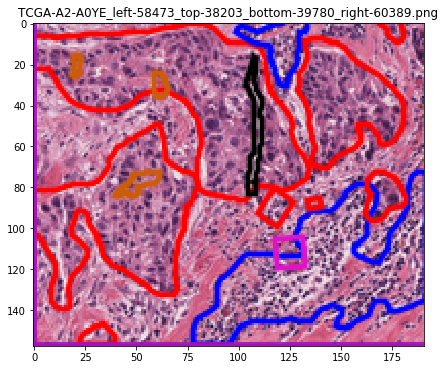

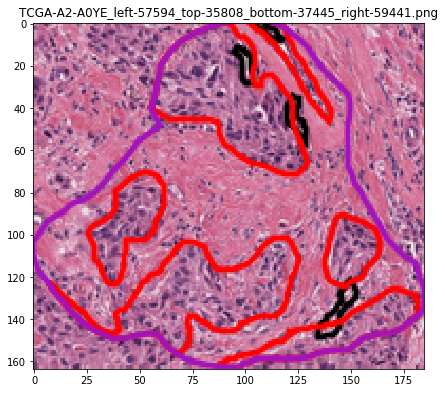

In [28]:
# visualization of contours over RGBs
for savename in savenames:
    vis = imread(savename["visualization"])
    plt.imshow(vis)
    plt.title(os.path.basename(savename["visualization"]))
    plt.show()

### Let's visualize the object mask

An object segmentation mask image uses the multiple channels to encode both class and instance information. In this mask format we multiply the second and third channel values to calculate a unique id for each object.

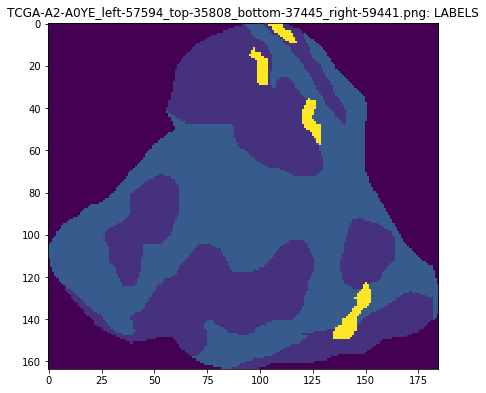

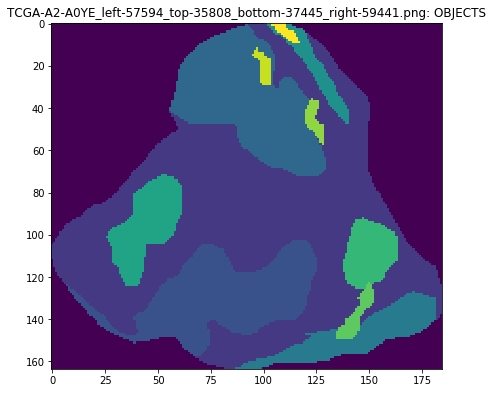

In [29]:
mask = imread(savename["mask"])
maskname = os.path.basename(savename["mask"]) 

plt.imshow(mask[..., 0])
plt.title(maskname + ': LABELS')
plt.show()

plt.imshow(mask[..., 1] * mask[..., 2])
plt.title(maskname + ': OBJECTS')
plt.show()